Class distribution: Class
M    211
H    142
L    127
Name: count, dtype: int64
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Model Accuracy: 0.80
Confusion Matrix:
 [[25  1  0]
 [ 6 34  8]
 [ 0  4 18]]


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



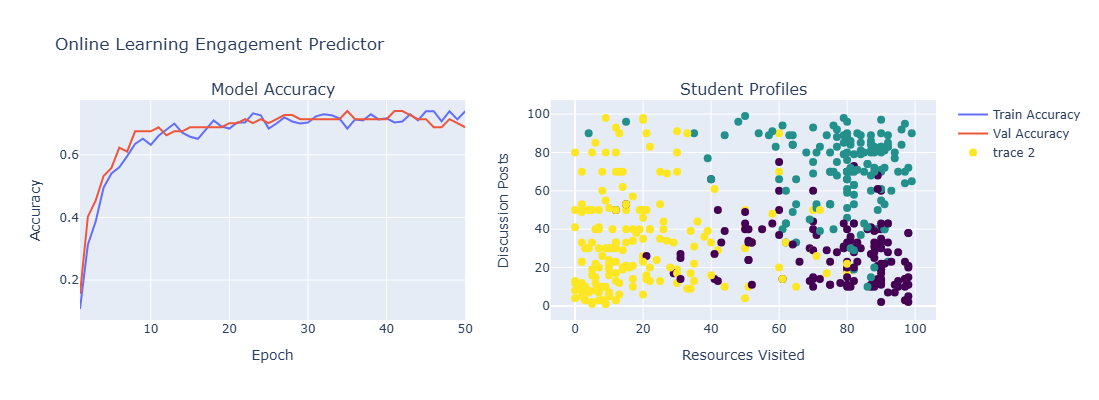

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Dashboard saved as 'engagement_dashboard.html'
Predictions saved as 'engagement_predictions.csv'
Suggestions saved as 'student_suggestions.csv'


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Load dataset
data = pd.read_csv("C:/Users/hp/Downloads/STUDENT_DATA.csv") # Or 'student_engagement.csv' for synthetic

# Check class distribution
print("Class distribution:", data['Class'].value_counts())

# Select more features
features = ['raisedhands', 'VisITedResources', 'AnnouncementsView', 'Discussion', 
            'StudentAbsenceDays', 'Relation', 'ParentAnsweringSurvey']
X = data[features]
# Encode categorical features
X = pd.get_dummies(X, columns=['StudentAbsenceDays', 'Relation', 'ParentAnsweringSurvey'], drop_first=True)
y = data['Class'].map({'L': 0, 'M': 1, 'H': 2})  # Low=0, Medium=1, High=2

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build deeper DNN
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Fix input_shape warning
    Dense(16, activation='relu'),     # More neurons
    Dropout(0.2),                     # Prevent overfitting
    Dense(8, activation='relu'),
    Dense(3, activation='softmax')    # 3 classes
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train with more epochs
history = model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0, validation_split=0.2)

# Test model
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Cluster students
kmeans = KMeans(n_clusters=3, random_state=42)
data['Profile'] = kmeans.fit_predict(X_scaled)

# Dashboard
fig = make_subplots(rows=1, cols=2, subplot_titles=("Model Accuracy", "Student Profiles"))
fig.add_trace(go.Scatter(x=list(range(1, 51)), y=history.history['accuracy'], mode='lines', name='Train Accuracy'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, 51)), y=history.history['val_accuracy'], mode='lines', name='Val Accuracy'), row=1, col=1)
fig.add_trace(go.Scatter(x=data['VisITedResources'], y=data['Discussion'], mode='markers', 
                         marker=dict(color=data['Profile'], colorscale='Viridis', size=8),
                         text=data['Class'].map({'L': 'Low', 'M': 'Medium', 'H': 'High'})), row=1, col=2)
fig.update_layout(title_text="Online Learning Engagement Predictor", height=400, width=800)
fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_xaxes(title_text="Resources Visited", row=1, col=2)
fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Discussion Posts", row=1, col=2)
fig.show()
fig.write_html("engagement_dashboard.html")

# Save predictions
test_predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
test_predictions.to_csv('engagement_predictions.csv', index=False)

# Intervention suggestions
sample_students = data.iloc[-5:].copy()
sample_students['Engagement_Pred'] = np.argmax(model.predict(X_scaled[-5:]), axis=1)
sample_students['Suggestion'] = sample_students.apply(
    lambda row: "Encourage forum posts" if row['Discussion'] < 20 else "Keep up resource use", axis=1)
sample_students.to_csv('student_suggestions.csv', index=False)

print("Dashboard saved as 'engagement_dashboard.html'")
print("Predictions saved as 'engagement_predictions.csv'")
print("Suggestions saved as 'student_suggestions.csv'")